# 🚀 Analisis Sentimen Ulasan Gojek  
### Submission Awal — Belajar Fundamental Deep Learning

---

## 📌 Deskripsi Proyek

Proyek ini merupakan submission awal untuk kelas **Belajar Fundamental Deep Learning (BFDL)**.  
Fokus utama proyek adalah **analisis sentimen ulasan pengguna aplikasi Gojek** yang diperoleh dari Google Play Store.  

Model utama yang digunakan adalah **DistilBERT**, dengan percepatan komputasi menggunakan **CUDA GPU**.

---

## 🗂️ Dataset

- Sumber: Google Play Store (web scraping)
- Berisi ulasan teks + rating
- Tujuan: mengklasifikasikan sentimen → *positif*, *negatif*, atau *netral*

---

## 👤 Identitas Pengembang

**Nama:** Septian Hadi Nugroho  
**Email:** septianhadinugroho4@gmail.com  

---



### **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    f1_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Utilities
from tqdm.auto import tqdm
import time
from datetime import datetime

# Check CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🖥️  Device: cuda
🎮 GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
💾 Memory: 4.29 GB


### **Load Dataset**

📊 Dataset Shape: (8371, 6)

📋 Columns: ['username', 'rating', 'review', 'date', 'thumbs_up', 'sentiment']

🔍 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8371 entries, 0 to 8370
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   username   8371 non-null   object
 1   rating     8371 non-null   int64 
 2   review     8371 non-null   object
 3   date       8371 non-null   object
 4   thumbs_up  8371 non-null   int64 
 5   sentiment  8371 non-null   object
dtypes: int64(2), object(4)
memory usage: 392.5+ KB

👀 Sample Data:
📊 Distribusi Sentimen:
sentiment
positif    4475
negatif    3474
netral      422
Name: count, dtype: int64

Persentase:
sentiment
positif    53.458368
negatif    41.500418
netral      5.041214
Name: count, dtype: float64


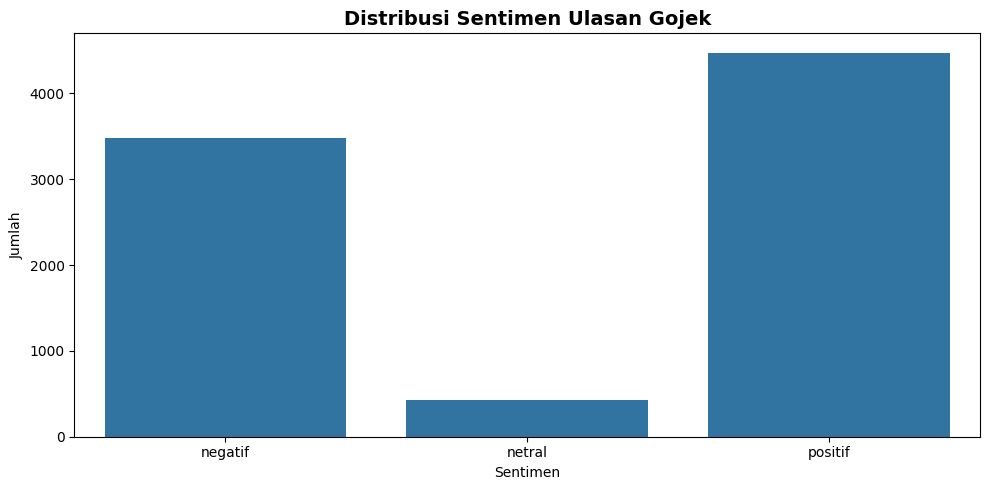

In [2]:
# Load dataset hasil scraping
df = pd.read_csv('gojek_reviews_20251209_115737.csv')

print(f"📊 Dataset Shape: {df.shape}")
print(f"\n📋 Columns: {df.columns.tolist()}")
print(f"\n🔍 Info:")
df.info()

#
# Preview data
print("\n👀 Sample Data:")
df.head(10)

#
# Statistik sentimen
print("📊 Distribusi Sentimen:")
sentiment_dist = df['sentiment'].value_counts()
print(sentiment_dist)
print(f"\nPersentase:")
print(sentiment_dist / len(df) * 100)

# Visualisasi
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='sentiment', order=['negatif', 'netral', 'positif'])
plt.title('Distribusi Sentimen Ulasan Gojek', fontsize=14, fontweight='bold')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

### **Balancing Data**

In [3]:
from sklearn.utils import resample
import pandas as pd

print("🔧 BALANCING DATA - CRITICAL FIX")
print("="*60)

# Pisahkan per kelas
df_positif = df[df['sentiment'] == 'positif']
df_negatif = df[df['sentiment'] == 'negatif']
df_netral = df[df['sentiment'] == 'netral']

print(f"Before balancing:")
print(f"  Positif: {len(df_positif)}")
print(f"  Negatif: {len(df_negatif)}")
print(f"  Netral:  {len(df_netral)}")

# Target: 3500 per kelas
TARGET = 3500

# Oversample netral (pakai replacement karena terlalu sedikit)
df_netral_balanced = resample(
    df_netral,
    replace=True,
    n_samples=TARGET,
    random_state=42
)

# Undersample positif (cukup banyak, bisa tanpa replacement)
df_positif_balanced = resample(
    df_positif,
    replace=False,
    n_samples=TARGET,
    random_state=42
)

# Oversample negatif sedikit (3474 → 3500, butuh replacement)
df_negatif_balanced = resample(
    df_negatif,
    replace=True,
    n_samples=TARGET,
    random_state=42
)

# Gabungkan
df = pd.concat([
    df_positif_balanced,
    df_negatif_balanced,
    df_netral_balanced
])

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ After balancing:")
print(f"  Total: {len(df)}")
print(df['sentiment'].value_counts())
print(f"\n🎯 Data siap untuk training!")

🔧 BALANCING DATA - CRITICAL FIX
Before balancing:
  Positif: 4475
  Negatif: 3474
  Netral:  422

✅ After balancing:
  Total: 10500
sentiment
negatif    3500
netral     3500
positif    3500
Name: count, dtype: int64

🎯 Data siap untuk training!


### **Data Preprocessing**

In [4]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()

stop_factory = StopWordRemoverFactory()
default_stopwords = stop_factory.get_stop_words()

# Kata negasi yang TIDAK BOLEH DIHAPUS
negation_words = ['tidak', 'bukan', 'jangan', 'belum', 'tak']

# Hapus kata negasi dari daftar stopword
custom_stopwords = [w for w in default_stopwords if w not in negation_words]

import re
import pandas as pd

def clean_text(text):
    if pd.isna(text): 
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def preprocess_text(text, use_stemming=True, use_stopword=True):
    text = clean_text(text)
    
    # Stopword manual (negasi aman)
    if use_stopword:
        words = text.split()
        words = [w for w in words if w not in custom_stopwords]
        text = " ".join(words)

    # Stemming
    if use_stemming:
        text = stemmer.stem(text)

    return text

from tqdm import tqdm
tqdm.pandas()

print("🧹 Preprocessing data...")
df['review_clean'] = df['review'].progress_apply(preprocess_text)

df = df[df['review_clean'].str.strip() != '']
df = df[df['review_clean'].str.len() >= 5]

print(f"✅ Data setelah preprocessing: {len(df)} rows")

print("\n👀 Contoh hasil:")
for i, row in df[['review', 'review_clean']].head(3).iterrows():
    print("\n---")
    print("Original:", row['review'][:120])
    print("Cleaned :", row['review_clean'][:120])


🧹 Preprocessing data...


100%|██████████| 10500/10500 [07:25<00:00, 23.55it/s] 

✅ Data setelah preprocessing: 10479 rows

👀 Contoh hasil:

---
Original: go food ekpres bayar lebih tpu tetap juga lama
Cleaned : go food ekpres bayar lebih tpu tetap lama

---
Original: nunggu dpt driver lama bgt satu jam lebih baru dpt. ini go food ya padahal ga hujan lho
Cleaned : nunggu dpt driver lama bgt satu jam lebih baru dpt go food padahal ga hujan lho

---
Original: pesen gocar di berau,kaltim, dr bandara ke rmh cuma 5 menit. byk driver g mau ambil alasan argo murah,mau nya ikut hrga 
Cleaned : sen gocar rau kaltim dr bandara rmh cuma menit byk driver g mau ambil alas argo murah mau nya ikut hrga travel apa bagai


### **Feature Extraction & Label Encoding**

In [5]:
# Label encoding
label_map = {'negatif': 0, 'netral': 1, 'positif': 2}
df['label'] = df['sentiment'].map(label_map)

print("🏷️  Label Mapping:")
for sentiment, label in label_map.items():
    print(f"   {sentiment} → {label}")

# Split data untuk semua percobaan
X = df['review_clean'].values
y = df['label'].values

# Split 1: 80/20
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split 2: 70/30
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split 3: 85/15
X_train_85, X_test_85, y_train_85, y_test_85 = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print("📊 Data Split Summary:")
print(f"   80/20 - Train: {len(X_train_80)}, Test: {len(X_test_80)}")
print(f"   70/30 - Train: {len(X_train_70)}, Test: {len(X_test_70)}")
print(f"   85/15 - Train: {len(X_train_85)}, Test: {len(X_test_85)}")

🏷️  Label Mapping:
   negatif → 0
   netral → 1
   positif → 2
📊 Data Split Summary:
   80/20 - Train: 8383, Test: 2096
   70/30 - Train: 7335, Test: 3144
   85/15 - Train: 8907, Test: 1572


### **PERCOBAAN 1: Random Forest + TF-IDF (80/20)**

In [6]:
print("="*60)
print("🔬 PERCOBAAN 1: Random Forest + TF-IDF (80/20)")
print("="*60)

# TF-IDF Vectorization
tfidf_1 = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf_1 = tfidf_1.fit_transform(X_train_80)
X_test_tfidf_1 = tfidf_1.transform(X_test_80)

print(f"📊 TF-IDF Shape: {X_train_tfidf_1.shape}")

# Train Random Forest
print("\n🌲 Training Random Forest...")
rf_model_1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=50,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_model_1.fit(X_train_tfidf_1, y_train_80)

# Predictions
y_train_pred_1 = rf_model_1.predict(X_train_tfidf_1)
y_test_pred_1 = rf_model_1.predict(X_test_tfidf_1)

# Metrics
train_acc_1 = accuracy_score(y_train_80, y_train_pred_1)
test_acc_1 = accuracy_score(y_test_80, y_test_pred_1)
f1_1 = f1_score(y_test_80, y_test_pred_1, average='weighted')

print(f"\n📈 RESULTS:")
print(f"   Train Accuracy: {train_acc_1*100:.2f}%")
print(f"   Test Accuracy:  {test_acc_1*100:.2f}%")
print(f"   F1-Score:       {f1_1:.4f}")

print(f"\n📊 Classification Report:")
print(classification_report(y_test_80, y_test_pred_1, 
                          target_names=['negatif', 'netral', 'positif']))

🔬 PERCOBAAN 1: Random Forest + TF-IDF (80/20)
📊 TF-IDF Shape: (8383, 5000)

🌲 Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s



📈 RESULTS:
   Train Accuracy: 96.42%
   Test Accuracy:  91.51%
   F1-Score:       0.9156

📊 Classification Report:
              precision    recall  f1-score   support

     negatif       0.88      0.91      0.89       700
      netral       1.00      0.96      0.98       700
     positif       0.88      0.87      0.87       696

    accuracy                           0.92      2096
   macro avg       0.92      0.91      0.92      2096
weighted avg       0.92      0.92      0.92      2096



[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.0s finished


### **PERCOBAAN 2: SVM + TF-IDF (70/30)**

In [7]:
print("="*60)
print("🔬 PERCOBAAN 2: SVM + TF-IDF (70/30)")
print("="*60)

# TF-IDF Vectorization
tfidf_2 = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_train_tfidf_2 = tfidf_2.fit_transform(X_train_70)
X_test_tfidf_2 = tfidf_2.transform(X_test_70)

print(f"📊 TF-IDF Shape: {X_train_tfidf_2.shape}")

# Train SVM
print("\n🎯 Training SVM...")
svm_model_2 = SVC(
    kernel='linear',
    C=1.0,
    random_state=42,
    verbose=True
)
svm_model_2.fit(X_train_tfidf_2, y_train_70)

# Predictions
y_train_pred_2 = svm_model_2.predict(X_train_tfidf_2)
y_test_pred_2 = svm_model_2.predict(X_test_tfidf_2)

# Metrics
train_acc_2 = accuracy_score(y_train_70, y_train_pred_2)
test_acc_2 = accuracy_score(y_test_70, y_test_pred_2)
f1_2 = f1_score(y_test_70, y_test_pred_2, average='weighted')

print(f"\n📈 RESULTS:")
print(f"   Train Accuracy: {train_acc_2*100:.2f}%")
print(f"   Test Accuracy:  {test_acc_2*100:.2f}%")
print(f"   F1-Score:       {f1_2:.4f}")

print(f"\n📊 Classification Report:")
print(classification_report(y_test_70, y_test_pred_2,
                          target_names=['negatif', 'netral', 'positif']))

🔬 PERCOBAAN 2: SVM + TF-IDF (70/30)
📊 TF-IDF Shape: (7335, 5000)

🎯 Training SVM...
[LibSVM]
📈 RESULTS:
   Train Accuracy: 94.42%
   Test Accuracy:  89.19%
   F1-Score:       0.8916

📊 Classification Report:
              precision    recall  f1-score   support

     negatif       0.87      0.85      0.86      1049
      netral       0.88      0.95      0.91      1050
     positif       0.94      0.87      0.90      1045

    accuracy                           0.89      3144
   macro avg       0.89      0.89      0.89      3144
weighted avg       0.89      0.89      0.89      3144



### **PERCOBAAN 3: DistilBERT (85/15)**

In [8]:
print("="*60)
print("🔬 PERCOBAAN 3: DistilBERT + Fine-tuning (85/15)")
print("="*60)

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = SentimentDataset(X_train_85, y_train_85, tokenizer)
test_dataset = SentimentDataset(X_test_85, y_test_85, tokenizer)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"📊 Dataset sizes:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches:  {len(test_loader)}")

# Load model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-multilingual-cased',
    num_labels=3
)
model = model.to(device)

# Optimizer & Scheduler
EPOCHS = 4
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"🎯 Training Config:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Total Steps: {total_steps}")

# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct_predictions/total_predictions:.4f}'
        })
    
    return correct_predictions / total_predictions, np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Evaluating')
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            losses.append(loss.item())
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return (correct_predictions / total_predictions, 
            np.mean(losses), 
            all_preds, 
            all_labels)

# Training loop
print("\n🚀 Starting Training...")
print("="*60)

history = {
    'train_acc': [],
    'train_loss': [],
    'test_acc': [],
    'test_loss': []
}

best_test_acc = 0

for epoch in range(EPOCHS):
    print(f"\n📅 Epoch {epoch + 1}/{EPOCHS}")
    print("-"*60)
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    test_acc, test_loss, _, _ = eval_model(model, test_loader, device)
    
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['test_acc'].append(test_acc.item())
    history['test_loss'].append(test_loss)
    
    print(f"\n📊 Epoch {epoch + 1} Results:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"   Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc*100:.2f}%")
    
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_distilbert_model.pt')
        print(f"   ✅ Best model saved! (Test Acc: {best_test_acc*100:.2f}%)")

# Load best model for final evaluation
model.load_state_dict(torch.load('best_distilbert_model.pt'))
test_acc_3, test_loss_3, y_test_pred_3, y_test_true_3 = eval_model(model, test_loader, device)

# Get train accuracy
train_acc_3, train_loss_3, y_train_pred_3, y_train_true_3 = eval_model(model, train_loader, device)

print("\n" + "="*60)
print("📈 FINAL RESULTS - PERCOBAAN 3 (DistilBERT)")
print("="*60)
print(f"   Train Accuracy: {train_acc_3*100:.2f}%")
print(f"   Test Accuracy:  {test_acc_3*100:.2f}%")

print(f"\n📊 Classification Report:")
print(classification_report(y_test_true_3, y_test_pred_3,
                          target_names=['negatif', 'netral', 'positif']))

🔬 PERCOBAAN 3: DistilBERT + Fine-tuning (85/15)
📊 Dataset sizes:
   Train batches: 279
   Test batches:  50


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🎯 Training Config:
   Epochs: 4
   Batch Size: 32
   Learning Rate: 2e-05
   Total Steps: 1116

🚀 Starting Training...

📅 Epoch 1/4
------------------------------------------------------------


Evaluating: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s]



📊 Epoch 1 Results:
   Train Loss: 0.7775 | Train Acc: 62.76%
   Test Loss:  0.5962 | Test Acc:  75.13%
   ✅ Best model saved! (Test Acc: 75.13%)

📅 Epoch 2/4
------------------------------------------------------------


Evaluating: 100%|██████████| 50/50 [00:04<00:00, 10.92it/s]



📊 Epoch 2 Results:
   Train Loss: 0.4711 | Train Acc: 82.27%
   Test Loss:  0.3181 | Test Acc:  89.44%
   ✅ Best model saved! (Test Acc: 89.44%)

📅 Epoch 3/4
------------------------------------------------------------


Evaluating: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]



📊 Epoch 3 Results:
   Train Loss: 0.2534 | Train Acc: 91.82%
   Test Loss:  0.2756 | Test Acc:  91.16%
   ✅ Best model saved! (Test Acc: 91.16%)

📅 Epoch 4/4
------------------------------------------------------------


Evaluating: 100%|██████████| 50/50 [00:04<00:00, 10.36it/s]



📊 Epoch 4 Results:
   Train Loss: 0.1711 | Train Acc: 94.96%
   Test Loss:  0.2511 | Test Acc:  92.24%
   ✅ Best model saved! (Test Acc: 92.24%)


Evaluating: 100%|██████████| 279/279 [00:26<00:00, 10.58it/s]


📈 FINAL RESULTS - PERCOBAAN 3 (DistilBERT)
   Train Accuracy: 96.67%
   Test Accuracy:  92.24%

📊 Classification Report:
              precision    recall  f1-score   support

     negatif       0.92      0.89      0.91       525
      netral       0.90      0.98      0.94       525
     positif       0.95      0.89      0.92       522

    accuracy                           0.92      1572
   macro avg       0.92      0.92      0.92      1572
weighted avg       0.92      0.92      0.92      1572



### **Inference**


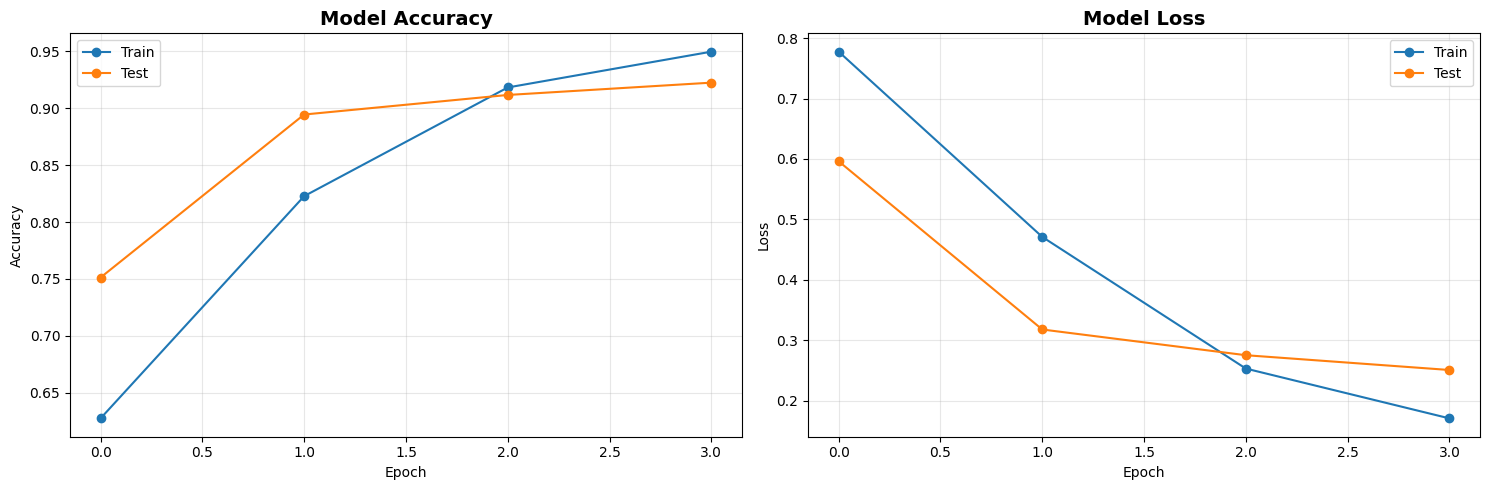

In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history['train_acc'], label='Train', marker='o')
axes[0].plot(history['test_acc'], label='Test', marker='o')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history['train_loss'], label='Train', marker='o')
axes[1].plot(history['test_loss'], label='Test', marker='o')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 PERBANDINGAN 3 PERCOBAAN
                  Model     Feature Extraction Data Split Train Accuracy (%) Test Accuracy (%) Status
 Random Forest + TF-IDF     TF-IDF (ngram 1-2)      80/20              96.42             91.51 ✅ >85%
           SVM + TF-IDF     TF-IDF (ngram 1-3)      70/30              94.42             89.19 ✅ >85%
DistilBERT (Fine-tuned) Transformer Embeddings      85/15              96.67             92.24 ⭐ >92%


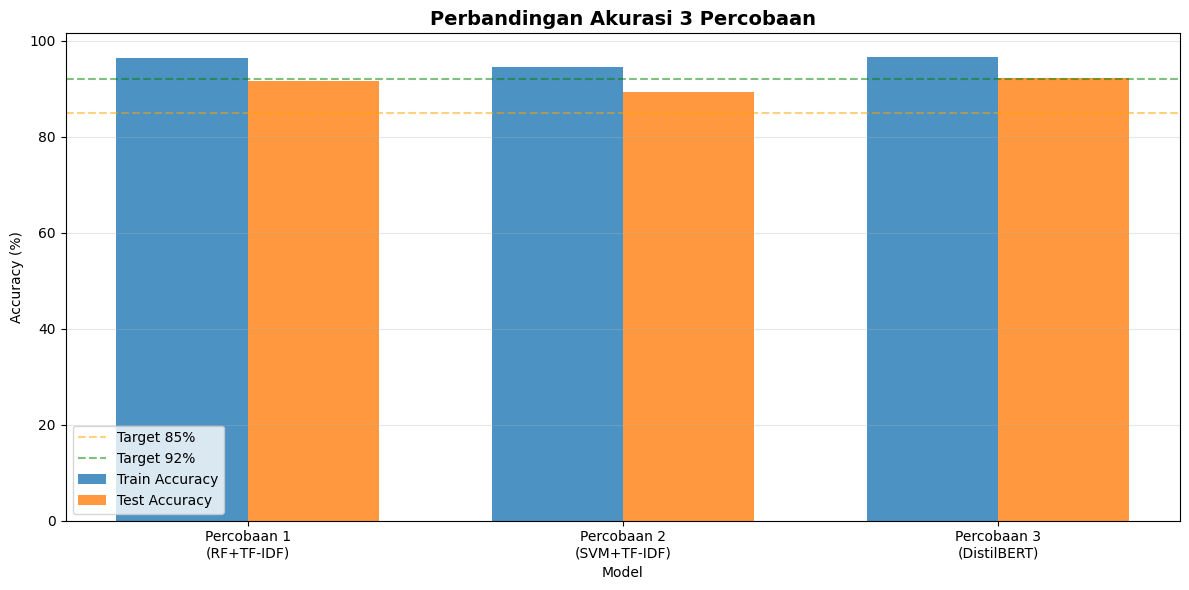

In [10]:
print("="*60)
print("📊 PERBANDINGAN 3 PERCOBAAN")
print("="*60)

results_df = pd.DataFrame({
    'Model': [
        'Random Forest + TF-IDF',
        'SVM + TF-IDF',
        'DistilBERT (Fine-tuned)'
    ],
    'Feature Extraction': [
        'TF-IDF (ngram 1-2)',
        'TF-IDF (ngram 1-3)',
        'Transformer Embeddings'
    ],
    'Data Split': ['80/20', '70/30', '85/15'],
    'Train Accuracy (%)': [
        f"{train_acc_1*100:.2f}",
        f"{train_acc_2*100:.2f}",
        f"{train_acc_3*100:.2f}"
    ],
    'Test Accuracy (%)': [
        f"{test_acc_1*100:.2f}",
        f"{test_acc_2*100:.2f}",
        f"{test_acc_3*100:.2f}"
    ],
    'Status': [
        '✅ >85%' if test_acc_1 >= 0.85 else '❌ <85%',
        '✅ >85%' if test_acc_2 >= 0.85 else '❌ <85%',
        '⭐ >92%' if test_acc_3 >= 0.92 else '✅ >85%' if test_acc_3 >= 0.85 else '❌ <85%'
    ]
})

print(results_df.to_string(index=False))

# Visualisasi
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

# Convert tensor ke float (untuk train_acc_3 & test_acc_3 yang dari DistilBERT)
train_accs = [
    train_acc_1*100, 
    train_acc_2*100, 
    train_acc_3.item()*100 if isinstance(train_acc_3, torch.Tensor) else train_acc_3*100
]

test_accs = [
    test_acc_1*100, 
    test_acc_2*100, 
    test_acc_3.item()*100 if isinstance(test_acc_3, torch.Tensor) else test_acc_3*100
]

bars1 = ax.bar(x - width/2, train_accs, width, label='Train Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy', alpha=0.8)

ax.axhline(y=85, color='orange', linestyle='--', label='Target 85%', alpha=0.5)
ax.axhline(y=92, color='green', linestyle='--', label='Target 92%', alpha=0.5)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Perbandingan Akurasi 3 Percobaan', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Percobaan 1\n(RF+TF-IDF)', 'Percobaan 2\n(SVM+TF-IDF)', 'Percobaan 3\n(DistilBERT)'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [11]:
print("="*60)
print("🎯 INFERENCE - Testing Model dengan Data Baru")
print("="*60)

def predict_sentiment(text, model, tokenizer, device):
    """Fungsi untuk prediksi sentimen dari text baru"""
    model.eval()
    
    # Preprocess
    text_clean = preprocess_text(text)
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text_clean,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        _, pred = torch.max(logits, dim=1)
    
    # Map label
    label_map_reverse = {0: 'negatif', 1: 'netral', 2: 'positif'}
    sentiment = label_map_reverse[pred.item()]
    confidence = probs[0][pred].item()
    
    return sentiment, confidence, probs[0].cpu().numpy()

🎯 INFERENCE - Testing Model dengan Data Baru


In [17]:
# Test dengan beberapa contoh review
test_reviews = [
    "Aplikasi gojek sangat membantu, driver ramah dan cepat sampai tujuan",
    "Aplikasi sering error dan crash, sangat mengecewakan",
    "Biasa aja sih, tidak ada yang spesial",
    "MANTAP BANGET! Gojek emang terbaik, pelayanan cepat dan harga terjangkau",
    "Aplikasi lemot banget, mau order susah, driver juga lama datangnya",
    "Driver ramah tapi aplikasinya sering bermasalah",
    "Harga mahal tapi pelayanan oke",
    "Aplikasi jelek, tidak recommended"
]

results_inference = []

for i, review in enumerate(test_reviews, 1):
    sentiment, confidence, probs = predict_sentiment(review, model, tokenizer, device)
    
    results_inference.append({
        'Review': review[:50] + '...' if len(review) > 50 else review,
        'Prediksi': sentiment.upper(),
        'Confidence': f"{confidence*100:.1f}%"
    })
    
    print(f"{'='*60}")
    print(f"Review {i}:")
    print(f"📝 Text: {review}")
    print(f"🎯 Prediksi: {sentiment.upper()} (Confidence: {confidence*100:.1f}%)")
    print(f"📊 Probabilitas:")
    print(f"   - Negatif: {probs[0]*100:.1f}%")
    print(f"   - Netral:  {probs[1]*100:.1f}%")
    print(f"   - Positif: {probs[2]*100:.1f}%")
    print()

# Tampilkan hasil dalam tabel
results_df_inference = pd.DataFrame(results_inference)
print("\n📋 RINGKASAN HASIL INFERENCE:")
print(results_df_inference.to_string(index=False))

Review 1:
📝 Text: Aplikasi gojek sangat membantu, driver ramah dan cepat sampai tujuan
🎯 Prediksi: POSITIF (Confidence: 99.4%)
📊 Probabilitas:
   - Negatif: 0.4%
   - Netral:  0.3%
   - Positif: 99.4%

Review 2:
📝 Text: Aplikasi sering error dan crash, sangat mengecewakan
🎯 Prediksi: NETRAL (Confidence: 60.0%)
📊 Probabilitas:
   - Negatif: 37.3%
   - Netral:  60.0%
   - Positif: 2.7%

Review 3:
📝 Text: Biasa aja sih, tidak ada yang spesial
🎯 Prediksi: NETRAL (Confidence: 85.7%)
📊 Probabilitas:
   - Negatif: 7.9%
   - Netral:  85.7%
   - Positif: 6.4%

Review 4:
📝 Text: MANTAP BANGET! Gojek emang terbaik, pelayanan cepat dan harga terjangkau
🎯 Prediksi: POSITIF (Confidence: 99.4%)
📊 Probabilitas:
   - Negatif: 0.3%
   - Netral:  0.4%
   - Positif: 99.4%

Review 5:
📝 Text: Aplikasi lemot banget, mau order susah, driver juga lama datangnya
🎯 Prediksi: NEGATIF (Confidence: 97.4%)
📊 Probabilitas:
   - Negatif: 97.4%
   - Netral:  0.3%
   - Positif: 2.2%

Review 6:
📝 Text: Driver ramah tapi 

In [18]:
# Save model dan tokenizer untuk deployment
print("💾 Menyimpan model dan tokenizer...")

# Save model
model.save_pretrained('./sentiment_model_distilbert')
tokenizer.save_pretrained('./sentiment_model_distilbert')

print("✅ Model dan tokenizer berhasil disimpan di folder: ./sentiment_model_distilbert")

💾 Menyimpan model dan tokenizer...
✅ Model dan tokenizer berhasil disimpan di folder: ./sentiment_model_distilbert
